REGRESSOR CNN

In [9]:
import os
import tensorflow as tf

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Configurazione manuale (più sicura)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("MEmory Growth attivata su GPU")
    except RuntimeError as e:
        print(e)

        
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_absolute_error
import gc

try:
    tf.config.experimental.enable_op_determinism()
    print("Op Determinism Abilitato!")
except AttributeError:
    print("Attenzione: La tua versione di TF è troppo vecchia per enable_op_determinism.")

def reset_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
SEEDS = [555]

MEmory Growth attivata su GPU
2.21.0-dev20251210
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Op Determinism Abilitato!


DATASET LOADING

In [10]:
def load_dataset():
    folder='dataset/images'
    data=[]
    for filename in sorted(os.listdir(folder)):   
        img_path=os.path.join(folder,filename)
        img=cv2.imread(img_path) #opencv save in bgr
        data.append({
            'image':img,
            'filename':filename
        })

    data_map = {item['filename']: item['image'] for item in data}
    label=pd.read_csv('dataset/raw/bbx_annotations.csv')
    #just to avoid warning
    coords = ['xmin', 'xmax', 'ymin', 'ymax']
    label[coords] = label[coords].astype(float)
    
    upper_mask = label['filename'].str.lower().str.contains('upper')
    label.loc[upper_mask, ['xmin', 'xmax', 'ymin', 'ymax']] /= 2
    
    for i,item in enumerate(data):
        if "upper" in item["filename"].lower():
            data[i]['image']=cv2.resize(
                data[i]['image'],
                (data[i]['image'].shape[1]//2,data[i]['image'].shape[0]//2)
                ,interpolation=cv2.INTER_AREA
            )
    return data, label

DATA MODELLING
train df will be: image--> w1, h1, w2,h2....w9,h9
where:w1 width of mean point of the bbox closer to x=0. if w9/h9 doesnt exist=-1 

In [11]:
def dataset_modelling(data,annotation):
    dataset_df = pd.DataFrame(data) 

    
    grouped = annotation.groupby('filename').agg(list).reset_index()
    merged = pd.merge(dataset_df, grouped, on='filename')
    MAX_OBJECTS = 9
    target_vectors = [] 
    class_vectors = []
    label_map={'goalpost':1,
               'ball':2,
               'robot':3,
               'goalspot':4,
               'centerspot':5}
    
    for i,row in merged.iterrows():
        temp_objects = []
        for j in range(len(row['xmin'])):
            xmin, xmax = row['xmin'][j], row['xmax'][j]
            ymin, ymax = row['ymin'][j], row['ymax'][j]
            cls_str = row['class'][j]
            cx = (xmin + xmax) / 2.0 / 320.0 
            cy = (ymin + ymax) / 2.0 / 240.0
            cls_id = label_map.get(cls_str, 0)
            temp_objects.append((cx, cy, cls_id))

        temp_objects.sort(key=lambda x: x[0])
        flat_target = []
        flat_class = []
        
        for obj in temp_objects:
            flat_target.extend([obj[0], obj[1]]) 
            flat_class.append(obj[2])

        target_len = MAX_OBJECTS * 2
        if len(flat_target) < target_len:
            flat_target.extend([0.0] * (target_len - len(flat_target)))
        elif len(flat_target) > target_len: #shouldnt happen
            flat_target = flat_target[:target_len]

        if len(flat_class) < MAX_OBJECTS:
            flat_class.extend([0] * (MAX_OBJECTS - len(flat_class)))
        elif len(flat_class) > MAX_OBJECTS:
            flat_class = flat_class[:MAX_OBJECTS]

        target_vectors.append(np.array(flat_target, dtype='float32'))
        class_vectors.append(np.array(flat_class, dtype='int32'))
    merged['target_vec'] = target_vectors
    merged['class_vec'] = class_vectors    


    train_df, test_df = train_test_split(merged, test_size=0.2, random_state=42)

    x_train_img = np.array(train_df['image'].tolist()).astype('float32') / 255.0
    x_train_class=np.array(train_df['class_vec'].tolist()).astype('float32')
    y_train = np.array(train_df['target_vec'].tolist()).astype('float32')

    x_test_img = np.array(test_df['image'].tolist()).astype('float32') / 255.0
    x_test_class= np.array(test_df['class_vec'].tolist()).astype('float32')
    y_test = np.array(test_df['target_vec'].tolist()).astype('float32')

    return x_train_img,x_train_class,y_train,x_test_img,x_test_class,y_test

PARAMETER SEARCH

In [12]:
def create_hyperparam_combination():
    param_grid = {
    'batch_size': [16],
    'layer_number':[6],
    'kernel_dim': [7],
    'pool_dim': [3], 
    'lr': [0.0001],
    'fc1' : [512],
    'fc2': [256],
    'class_out':[32],
    'activation':['relu'],
    'dropout':[0.2]
      
}

    #every possible combination
    keys, values = zip(*param_grid.items())
    combinations = list(itertools.product(*values))
    combinations_dicts = [dict(zip(keys, v)) for v in combinations]
    return combinations_dicts

BUILDING MODEL

In [13]:
def build_model(layer_num,kernel_dim,pool_dim,fc1,fc2,activation,clas_out,drop):
    input_img = Input(shape=(240, 320, 3), name='input_image')
    x = input_img
    filters = 16
    for i in range(layer_num):
        x = layers.Conv2D(filters, (kernel_dim, kernel_dim), activation=activation, padding='same')(x)
        x = layers.AveragePooling2D((pool_dim,pool_dim),strides=2,padding='same')(x)
        x = layers.Dropout(drop)(x)

        filters = min(filters * 2, 512)
    
    feat_img = layers.GlobalAveragePooling2D()(x) 
    input_classes = Input(shape=(9,), name='input_classes')
    y = layers.Embedding(input_dim=6, output_dim=clas_out)(input_classes)
    y = layers.Flatten()(y)

    combined = layers.Concatenate()([feat_img, y])
    z = layers.Dense(fc1, activation='relu')(combined)
    z = layers.Dense(fc2, activation='relu')(z)

    output = layers.Dense(18, activation='sigmoid')(z)
    model = models.Model(inputs=[input_img, input_classes], outputs=output)
    
   

    #model.summary()
    return model

SAVE CSV

In [14]:
def save_csv(mae,param,seed,all_results,r2):
    current_result = param.copy()  
    current_result['mae_Score']=mae
    current_result['R2_Score']=r2


    all_results.append(current_result)

    pd.DataFrame(all_results).to_csv(f'regression/csv/search/multi_input2_mse_appoggio_{seed}.csv', index=False)

VISUALIZING DATA

In [15]:

def visualize_only_centers(model, x_test, y_test,seed):
    index_list=[1,12,21,34,25,46,14,19,40]
    for index in index_list:
        img_norm = x_test[0][index].copy()  
        input_class = x_test[1][index]      
        
        real_targets = y_test[index]
        
        sample_img_batch = x_test[0][index:index+1]
        sample_cls_batch = x_test[1][index:index+1]
        
        pred_targets = model.predict([sample_img_batch, sample_cls_batch], verbose=0)[0]
        
        if img_norm.max() <= 1.0:
            img_display = (img_norm * 255).astype(np.uint8)
        else:
            img_display = img_norm.astype(np.uint8)
            
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
        
        IMG_H, IMG_W = img_display.shape[:2]
        
        print(f"\n--- Analisi Centri Immagine {index} ---")

        def draw_points(targets, color, label):
            for i in range(0, len(targets), 2):
                if i+1 >= len(targets): break
                
                xc = targets[i]
                yc = targets[i+1]
                
                if xc < 0.01 and yc < 0.01: continue
                
                xc_px = int(xc * IMG_W)
                yc_px = int(yc * IMG_H)
                
                cv2.circle(img_display, (xc_px, yc_px), 3, color, -1)
                
                cv2.circle(img_display, (xc_px, yc_px), 5, (255, 255, 255), 1)
                
                print(f"{label} {i//2+1}: ({xc_px}, {yc_px}) px")

        draw_points(real_targets, (0, 255, 0), "Reale")    # Verde
        draw_points(pred_targets, (255, 0, 0), "Predetto") # Rosso

        plt.figure(figsize=(6,6))
        plt.imshow(img_display)
        plt.title(f"Img {index}: green=REAL  red=PREDICTION")
        plt.axis('off')
        
        save_path=f'regression/images/predvstrue/2img_mse_vere_{index}_seed{seed}'
        
        plt.savefig(save_path, bbox_inches='tight') 
        
        plt.show()
        plt.close()

MAIN


 ================== INIZIO CICLO CON SEED: 555 ================== 
ITERAZIONE 1 of 1
PARAMETRI ATTUALI: {'batch_size': 16, 'layer_number': 6, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'relu', 'dropout': 0.2}
Epoch 1/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0560 - mae: 0.1386 - val_loss: 0.0391 - val_mae: 0.1240
Epoch 2/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0378 - mae: 0.1194 - val_loss: 0.0385 - val_mae: 0.1441
Epoch 3/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0337 - mae: 0.1134 - val_loss: 0.0322 - val_mae: 0.1346
Epoch 4/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0254 - mae: 0.0982 - val_loss: 0.0217 - val_mae: 0.0987
Epoch 5/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0189 - mae: 0.0789 - val_loss: 0.0165 - val_mae: 0.0774
Epoch 6/120
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0156 - mae: 0.0691 - val_loss: 0.0142 - val_mae: 0.0678
Epoch 7/120
88/88 ━━━━━━

E0000 00:00:1765907232.891771    4633 node_def_util.cc:682] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE: 0.022538259625434875

--- ESEMPIO PREDIZIONE ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Reale (primi 4 valori): [0.05625    0.203125   0.16328125 0.18958333]
Predetto (primi 4 valori): [0.0261848  0.28045455 0.19158153 0.18702747]
{'batch_size': 16, 'layer_number': 6, 'kernel_dim': 7, 'pool_dim': 3, 'lr': 0.0001, 'fc1': 512, 'fc2': 256, 'class_out': 32, 'activation': 'relu', 'dropout': 0.2, 'seed': 555, 'best_mae_score': 0.022538259625434875, 'best_r2_score': 0.7717732787132263}

--- Analisi Centri Immagine 1 ---
Reale 1: (212, 49) px
Reale 2: (247, 26) px
Predetto 1: (62, 38) px
Predetto 2: (162, 15) px


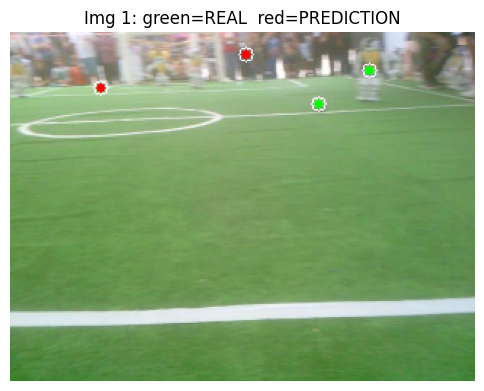


--- Analisi Centri Immagine 12 ---
Reale 1: (56, 21) px
Reale 2: (243, 50) px
Predetto 1: (65, 31) px
Predetto 2: (251, 68) px


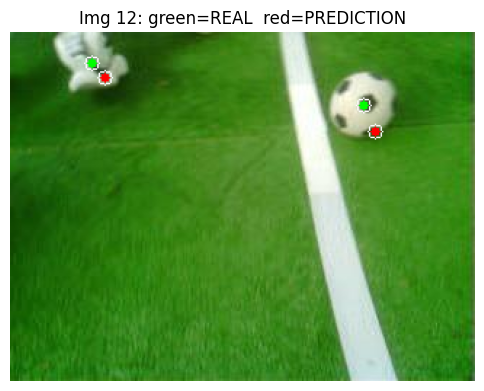


--- Analisi Centri Immagine 21 ---
Reale 1: (29, 182) px
Predetto 1: (29, 183) px


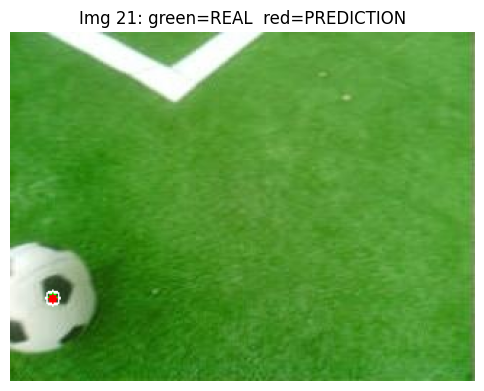


--- Analisi Centri Immagine 34 ---
Reale 1: (296, 107) px
Predetto 1: (170, 27) px
Predetto 2: (4, 0) px


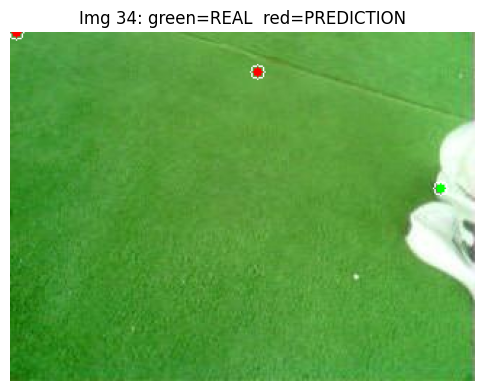


--- Analisi Centri Immagine 25 ---
Reale 1: (64, 39) px
Reale 2: (65, 63) px
Reale 3: (84, 28) px
Reale 4: (120, 33) px
Reale 5: (160, 26) px
Reale 6: (218, 42) px
Predetto 1: (61, 44) px
Predetto 2: (73, 86) px
Predetto 3: (49, 22) px
Predetto 4: (114, 31) px
Predetto 5: (170, 31) px
Predetto 6: (236, 32) px
Predetto 9: (3, 0) px


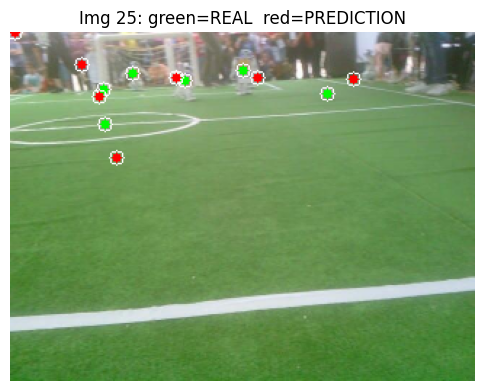


--- Analisi Centri Immagine 46 ---
Reale 1: (74, 148) px
Predetto 1: (92, 129) px


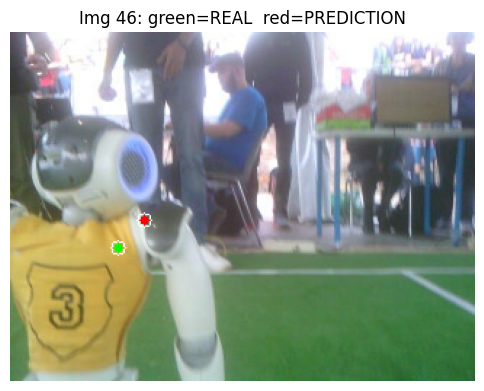


--- Analisi Centri Immagine 14 ---
Reale 1: (29, 52) px
Reale 2: (164, 22) px
Predetto 1: (12, 46) px
Predetto 2: (95, 35) px


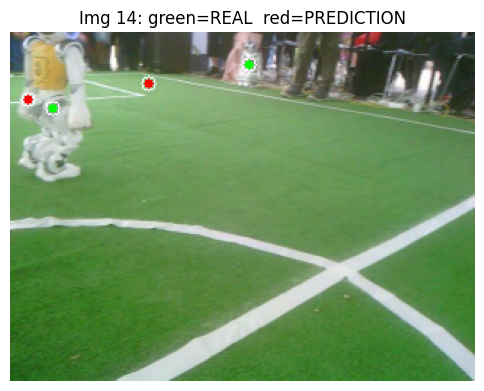


--- Analisi Centri Immagine 19 ---
Reale 1: (73, 178) px
Reale 2: (89, 186) px
Reale 3: (110, 188) px
Reale 4: (129, 180) px
Reale 5: (253, 229) px
Reale 6: (293, 197) px
Predetto 1: (18, 147) px
Predetto 2: (33, 179) px
Predetto 3: (73, 163) px
Predetto 4: (181, 142) px
Predetto 5: (222, 165) px
Predetto 6: (251, 145) px
Predetto 7: (9, 8) px


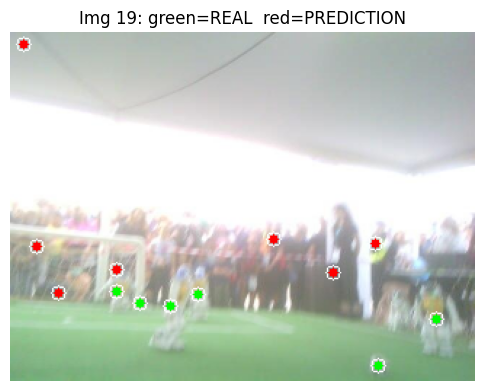


--- Analisi Centri Immagine 40 ---
Reale 1: (122, 66) px
Reale 2: (270, 49) px
Predetto 1: (110, 71) px
Predetto 2: (219, 50) px


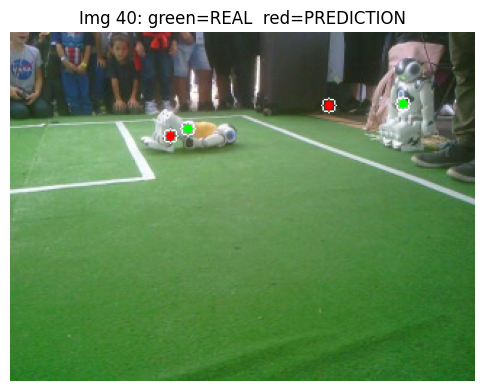

In [16]:
data,annotation=load_dataset()
x_train_img,x_train_class,y_train,x_test_img,x_test_class,y_test=dataset_modelling(data,annotation)
combination=create_hyperparam_combination()
total_combinations = len(combination)
x_train=[x_train_img,x_train_class]
x_test=[x_test_img,x_test_class]

final_results = []
for seed in SEEDS:
    print(f"\n ================== INIZIO CICLO CON SEED: {seed} ================== ")
    all_results = []
    bestmae=100000
    best_r2=-1000000
    current_seed_best_params = {}
    best_model_path = f"temp_best_model_seed_{seed}.keras"
    for i,param in enumerate(combination):
        print(f"ITERAZIONE {i+1} of {total_combinations}")
        print(f"PARAMETRI ATTUALI: {param}")     
        tf.keras.backend.clear_session()
        gc.collect()
        reset_seeds(seed)

        model=build_model( param['layer_number'],param['kernel_dim'],param['pool_dim'],param['fc1'],param['fc2'],param['activation'],param['class_out'],param['dropout'])

        opt=tf.keras.optimizers.Adam(learning_rate=param['lr'])

        model.compile(optimizer=opt,
                        loss='mse',
                        metrics=['mae'])
        
        early_stop=EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
            )
        
        reset_seeds(seed)
        history=model.fit(
                x_train,y_train,
                epochs=120,
                batch_size=param['batch_size'], 
                validation_split=0.2, 
                callbacks=[early_stop]
                )
        
        y_pred=model.predict(x_test)

        mae = mean_absolute_error(y_test, y_pred)
        r2=r2_score(y_test,y_pred)
        print("MAE:", mae)

        if mae<bestmae:
            bestmae=mae
            current_seed_best_params = param.copy()
            best_r2=r2
            model.save(best_model_path)
        save_csv(mae,param,seed,all_results,r2)

        print("\n--- ESEMPIO PREDIZIONE ---")
        idx = 80
        real_vals = y_test[idx]
        img_sample = x_test[0][idx:idx+1]   
        cls_sample = x_test[1][idx:idx+1]   

        pred_vals = model.predict([img_sample, cls_sample])[0]
        print(f"Reale (primi 4 valori): {real_vals[:4]}")
        print(f"Predetto (primi 4 valori): {pred_vals[:4]}")


    current_seed_best_params['seed'] = seed
    current_seed_best_params['best_mae_score'] = bestmae
    current_seed_best_params['best_r2_score'] = best_r2
    best_model = tf.keras.models.load_model(best_model_path)
    print(current_seed_best_params)
    visualize_only_centers(best_model, x_test, y_test,seed)
   

    final_results.append(current_seed_best_params)

df_best_results = pd.DataFrame(final_results)
#df_best_results.to_csv('regression/csv/best_model/multiinput2_mse.csv', index=False)


